In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.gridspec as gridspec
import textwrap
import os
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import numpy as np
import seaborn as sns

column_time = 'TimeIndice'
time_series_columns = ['HeartRate', 'VelocityX', 'VelocityY', 'VelocityZ', 'RotationX', 'RotationY', 'RotationZ']

def load_data(file_path, column_time):
    print(file_path)
    df = pd.read_csv(file_path)
    print(file_path)
    # Remove rows where TimeIndice is NaN
    df = df[df[column_time].notna()]
    
    # Convert all string columns to lowercase
    df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
    return df

def extract_timestamps(df, column_time, record_index):
    series_time = df[column_time].iloc[record_index]
    timestamps = [datetime.strptime(x.strip(), '%H:%M:%S.%f') for x in series_time.split(';') if x.strip()]
    
    return timestamps

def plot_data(df, timestamps, columns, record_index):
    n = len(columns)
    n_rows = (n + 1) // 2
    
    gs = gridspec.GridSpec(n_rows + 1, 2, height_ratios=[0.1] + [1]*n_rows)
    fig = plt.figure(figsize=(20, 2.5 * (n_rows + 1)))
    
    ax_text = fig.add_subplot(gs[0, :])
    ax_text.axis('off')
    
    all_columns = set(df.columns)
    plottable_columns = set(columns + [column_time])
    info_columns = list(all_columns - plottable_columns)
    
    if info_columns:
        info_text = "\t\t".join([f"{col}: {df[col].iloc[record_index]}" for col in info_columns])
        wrapped_text = textwrap.fill(info_text, width=220)
        ax_text.text(0, 0.5, wrapped_text, ha='left', va='center', fontsize=13)
    
    axs = [fig.add_subplot(gs[i+1, j]) for i in range(n_rows) for j in range(2)]
    
    for idx, ax in enumerate(axs[:n]):
        column = columns[idx]
        series_data = df[column].iloc[record_index]
        data_values = [float(x.strip()) for x in series_data.split(';') if x.strip()]

        ax.plot(timestamps, data_values, label=column)
        ax.set_title(column)
        ax.set_xlabel('Time Index')
        ax.set_ylabel('Data Values')
        ax.grid(True)
        ax.legend()
        
    if n % 2 != 0:
        axs[-1].axis('off')
        
    plt.tight_layout()
    plt.show()

def plot_smooth_data(df, timestamps, columns, record_index, smoothness):
    n = len(columns)
    n_rows = (n + 1) // 2
    
    gs = gridspec.GridSpec(n_rows + 1, 2, height_ratios=[0.1] + [1]*n_rows)
    fig = plt.figure(figsize=(20, 2.5 * (n_rows + 1)))
    
    ax_text = fig.add_subplot(gs[0, :])
    ax_text.axis('off')
    
    all_columns = set(df.columns)
    plottable_columns = set(columns + [column_time])
    info_columns = list(all_columns - plottable_columns)
    
    if info_columns:
        info_text = "\t\t".join([f"{col}: {df[col].iloc[record_index]}" for col in info_columns])
        wrapped_text = textwrap.fill(info_text, width=220)
        ax_text.text(0, 0.5, wrapped_text, ha='left', va='center', fontsize=13)
    
    axs = [fig.add_subplot(gs[i+1, j]) for i in range(n_rows) for j in range(2)]
    
    for idx, ax in enumerate(axs[:n]):
        column = columns[idx]
        series_data = df[column].iloc[record_index]
        data_values = [float(x.strip()) for x in series_data.split(';') if x.strip()]

        # Create a cubic spline interpolation of the data
        spline = UnivariateSpline(range(len(data_values)), data_values, s=smoothness)
        x_new = np.linspace(0, len(data_values) - 1, 1000)
        y_new = spline(x_new)

        ax.plot(x_new, y_new, label=column)
        ax.set_title(column)
        ax.set_xlabel('Time Index')
        ax.set_ylabel('Data Values')
        ax.grid(True)
        ax.legend()
        
    if n % 2 != 0:
        axs[-1].axis('off')
        
    plt.tight_layout()
    plt.show()
    
# Get a list of CSV files in the current directory
csv_files = [file for file in os.listdir('./') if file.endswith('.csv')]

# Initialize an empty dataframe to store concatenated data
all_data = pd.DataFrame()

# Iterate over CSV files and concatenate them
for file_path in csv_files:
    if file_path != 'all_data.csv':
        df = load_data(file_path, column_time)
        all_data = pd.concat([all_data, df], ignore_index=True)

# Load the original data from all_data.csv
original_data = load_data('all_data.csv', column_time)

# Append the data from other CSV files to all_data
all_data = pd.concat([original_data, all_data], ignore_index=True)

# Remove duplicates based on the "Id" column in all_data
all_data = all_data.drop_duplicates(subset=['Id'])

all_data['Name'] = all_data['Name'].str.strip()

# Sort the concatenated dataframe based on the "Id" column
all_data['Id'] = pd.to_datetime(all_data['Id'])
all_data = all_data.sort_values(by='Id')

# Reset the index after sorting
all_data = all_data.reset_index(drop=True)

# Save the updated all_data to all_data.csv
all_data.to_csv('all_data.csv', index=False)
all_data.to_excel('all_data.xlsx', index=False)


20-09-2023-huawei.csv
20-09-2023-huawei.csv
21-09-2023-huawei.csv
21-09-2023-huawei.csv
23-09-2023-huawei.csv


C:\Users\mujugen\AppData\Local\Temp\ipykernel_20604\2804347793.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
C:\Users\mujugen\AppData\Local\Temp\ipykernel_20604\2804347793.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


23-09-2023-huawei.csv
27-09-2023-huawei.csv
27-09-2023-huawei.csv
27-09-2023-sam.csv


C:\Users\mujugen\AppData\Local\Temp\ipykernel_20604\2804347793.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
C:\Users\mujugen\AppData\Local\Temp\ipykernel_20604\2804347793.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


27-09-2023-sam.csv
all_data.csv


C:\Users\mujugen\AppData\Local\Temp\ipykernel_20604\2804347793.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


all_data.csv


C:\Users\mujugen\AppData\Local\Temp\ipykernel_20604\2804347793.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


In [32]:
record_index = 487

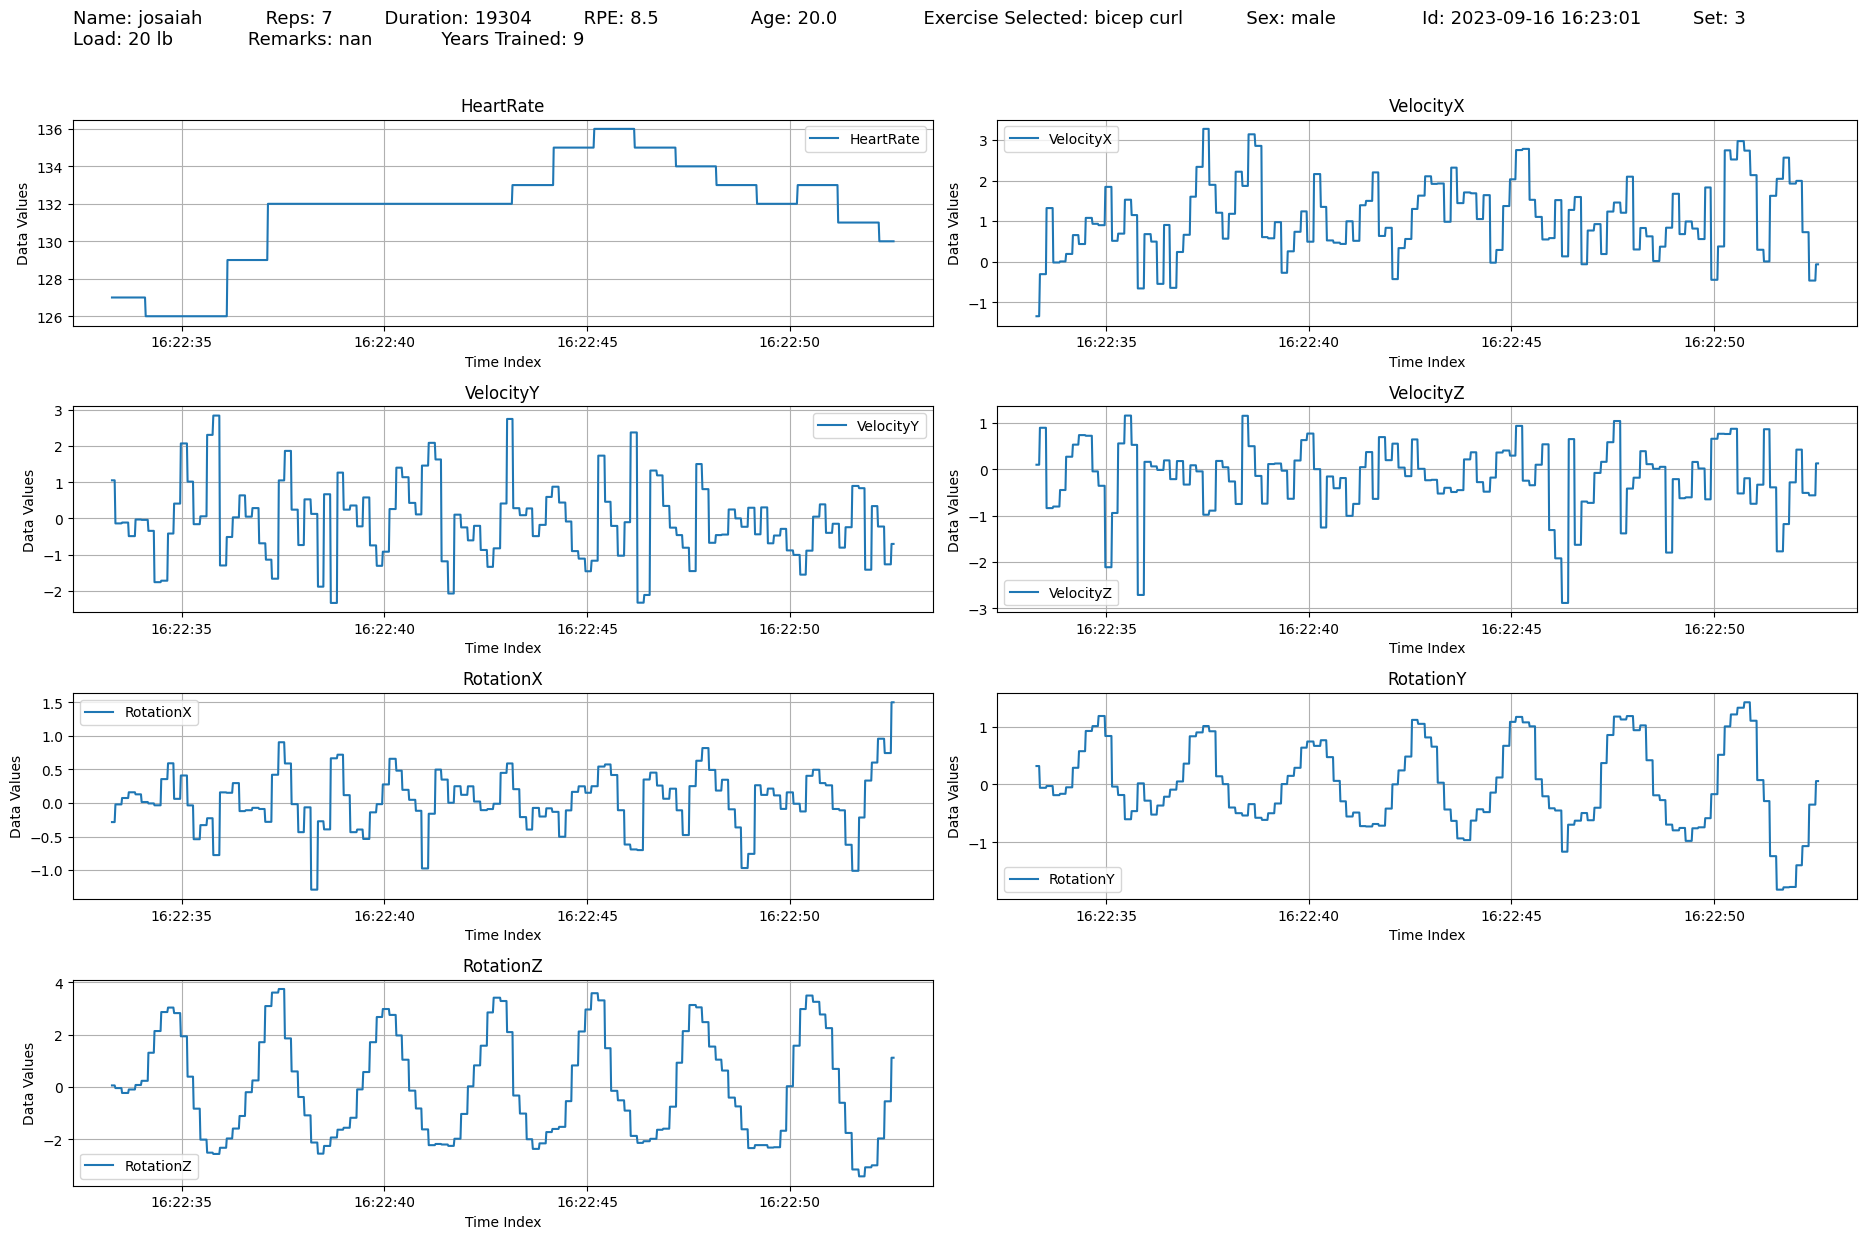

In [33]:
timestamps = extract_timestamps(all_data, column_time, record_index)
original_data = all_data.loc[:,['Set', 'Name', 'Exercise Selected', 'Load', 'Reps', 'RPE', 'Remarks', 'Age', 'Duration', 'Sex', 'Id','Years Trained', 'HeartRate', 'VelocityX', 'VelocityY', 'VelocityZ', 'RotationX', 'RotationY', 'RotationZ', 'TimeIndice']]
plot_data(original_data, timestamps, time_series_columns, record_index)



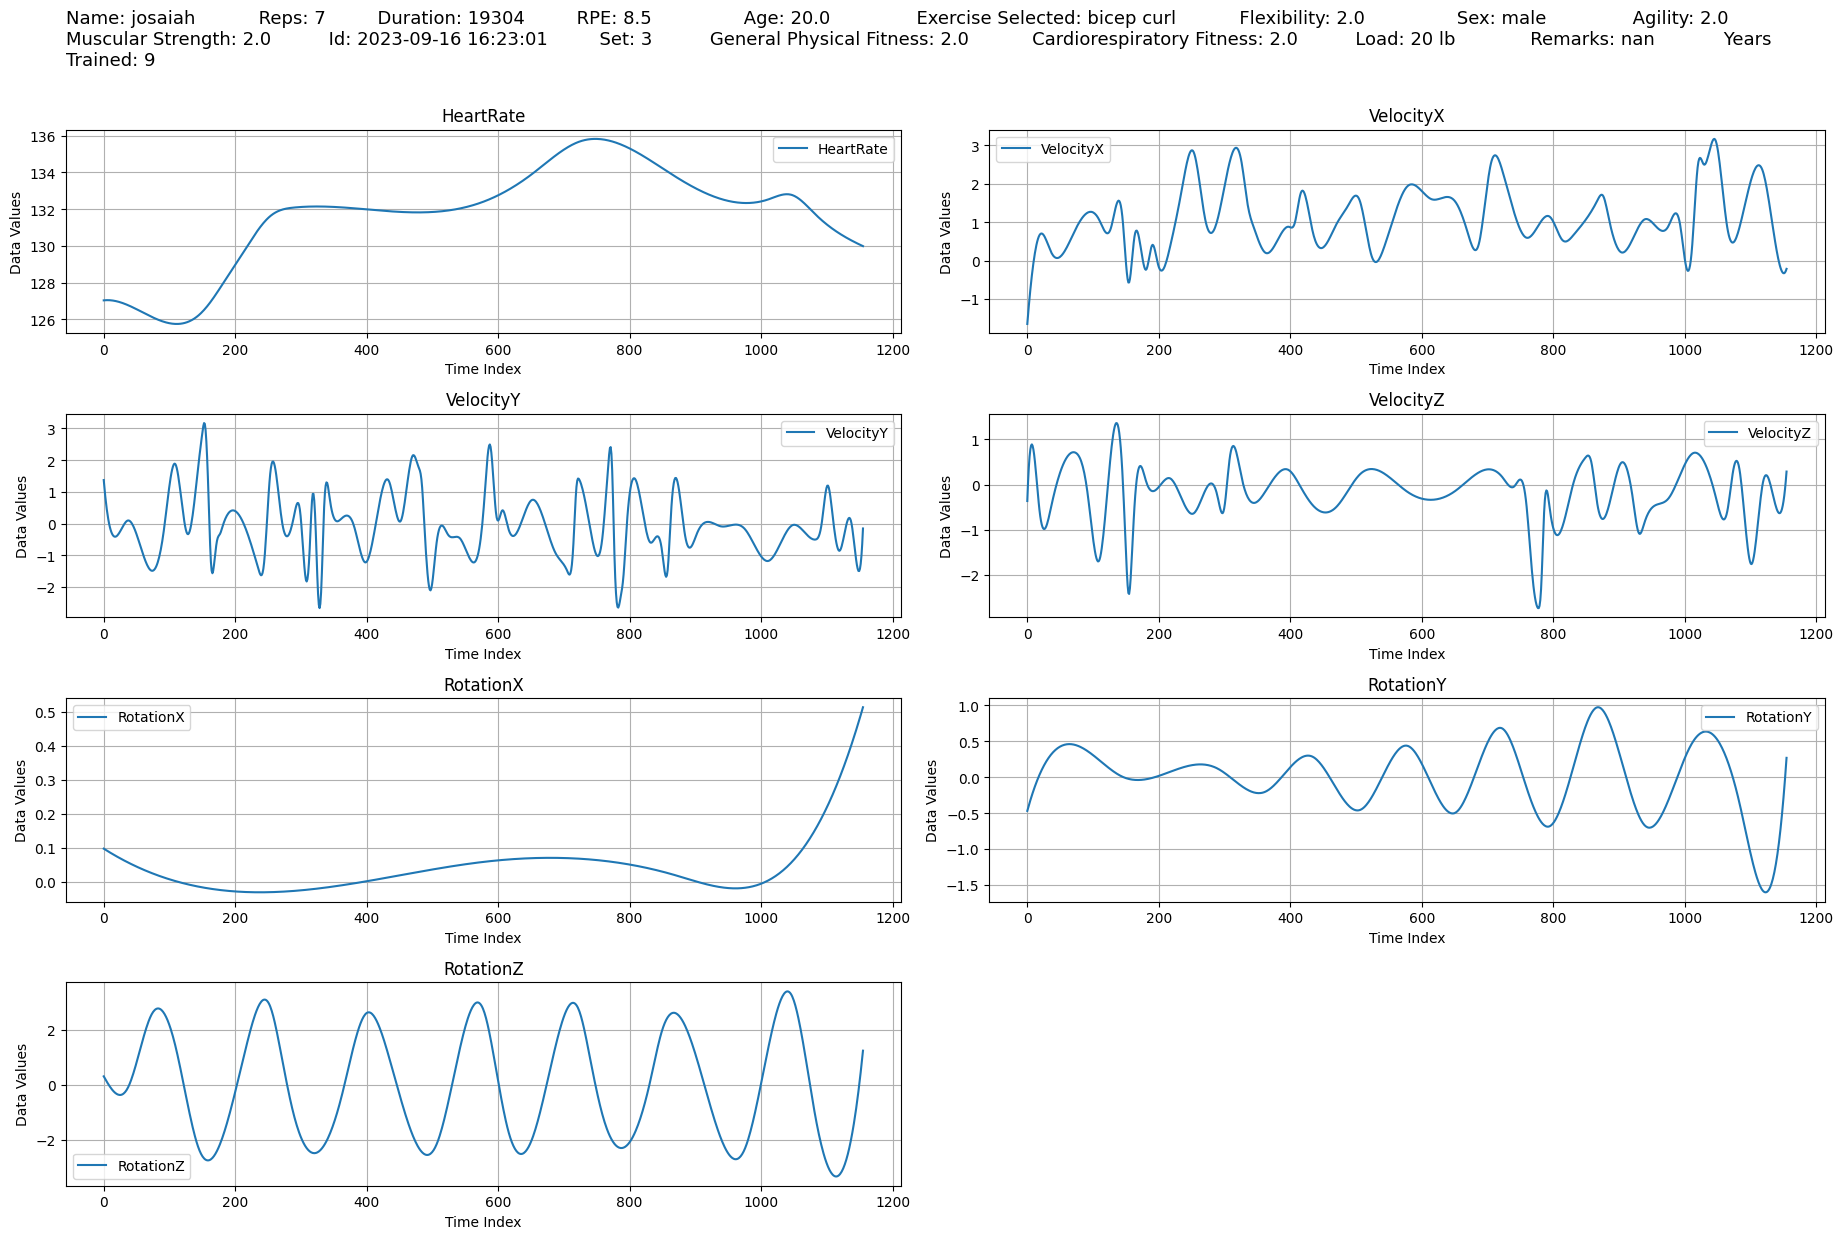

In [34]:
plot_smooth_data(all_data, timestamps, time_series_columns, record_index, 200)

In [35]:
filtered_df = all_data[all_data['Remarks'].notnull()]

# Display only the "Remarks" column
print(filtered_df['Remarks'])


17                                  55555
24                            hello world
25                            hello world
26                             late start
100                                sitted
101                                sitted
102                                sitted
103                                 cable
104                                 cable
122                         improper form
123              improper form at the end
129                             bench 1st
153               change firdt set to 3!4
218                     technogym machine
221                              dropset 
240                            cross body
241                                 cross
320                             technogym
325                            incomplete
326                           experienced
335                             technogym
336                             technogym
355                change experience to 1
370                             in

In [36]:
all_data.drop(all_data[all_data['Name'] == 'test'].index, inplace=True)
all_data.drop(all_data[all_data['Remarks'] == 'test'].index, inplace=True)

In [37]:
for i in all_data.index:
    heart_rate = all_data['HeartRate'][i].split(';')
    velocity_x = all_data['VelocityX'][i].split(';')
    velocity_y = all_data['VelocityY'][i].split(';')
    velocity_z = all_data['VelocityZ'][i].split(';')
    rotation_x = all_data['RotationX'][i].split(';')
    rotation_y = all_data['RotationY'][i].split(';')
    rotation_z = all_data['RotationZ'][i].split(';')
    
    # Check if all lists have the same length
    if not (len(heart_rate) == len(velocity_x) == len(velocity_y) == len(velocity_z) == len(rotation_x) == len(rotation_y) == len(rotation_z)):
        all_data = all_data.drop(i)


In [38]:
all_data.loc[:, 'Exercise Selected'] = all_data.loc[:, 'Exercise Selected'].replace('squat', 'hammer curl')
all_data.loc[:, 'Exercise Selected'] = all_data.loc[:, 'Exercise Selected'].replace('cross body hammer curl', 'hammer curl')
all_data.loc[:, 'Exercise Selected'] = all_data.loc[:, 'Exercise Selected'].replace('deadlift', 'lat pulldown')
all_data.loc[:, 'Exercise Selected'] = all_data.loc[:, 'Exercise Selected'].replace('tricep kickback', 'tricep pushdown')
all_data.loc[:, 'Exercise Selected'] = all_data.loc[:, 'Exercise Selected'].replace('triceps pushdown', 'tricep pushdown')
all_data.loc[:, 'Exercise Selected'] = all_data.loc[:, 'Exercise Selected'].replace('lunges', 'chest fly')

In [39]:
all_data['Name'] = all_data['Name'].replace('kalki', 'kalki lamadrid')
all_data['Name'] = all_data['Name'].replace('deuz', 'deuz amparo')
all_data['Name'] = all_data['Name'].replace('duwi', 'dewey cabasaan')
all_data['Name'] = all_data['Name'].replace('doreen', 'doreen mendoza')
all_data['Name'] = all_data['Name'].replace('keith', 'keith gerard anciro')
all_data['Name'] = all_data['Name'].replace('jayden', 'jayden reyes')
all_data['Name'] = all_data['Name'].replace('ronn', 'ronn angkico')

In [40]:
dfPage = 0
all_data.loc[dfPage*50:(dfPage+1)*50,['Set', 'Name', 'Exercise Selected', 'Load', 'Reps', 'RPE', 'Remarks', 'Duration', 'Id','Years Trained']]

,Set,Name,Exercise Selected,Load,Reps,RPE,Remarks,Duration,Id,Years Trained
0,1,kalki lamadrid,lat pulldown,21 kg,12,3-4,NaN,47658,2023-09-01 22:08:52,5
1,1,kalki lamadrid,lat pulldown,21 kg,12,3-4,NaN,47586,2023-09-01 22:09:20,5
2,1,kalki lamadrid,back rows,21 kg,10,5-6,NaN,43633,2023-09-01 22:12:42,5
3,1,kalki lamadrid,back rows,21 kg,10,5-6,NaN,43615,2023-09-01 22:13:06,5
4,1,kalki lamadrid,bicep curl,21 kg,12,7,NaN,50712,2023-09-01 22:18:27,5
5,1,kalki lamadrid,bicep curl,21 kg,12,7,NaN,50726,2023-09-01 22:18:58,5
6,1,kalki lamadrid,back rows,34 kg,12,7.5,NaN,37685,2023-09-01 22:26:42,5
7,1,kalki lamadrid,back rows,34 kg,12,7.5,NaN,37730,2023-09-01 22:26:58,5
8,2,kalki lamadrid,back rows,34 kg,12,7.5,NaN,44728,2023-09-01 22:29:36,5
9,2,kalki lamadrid,back rows,34 kg,12,7.5,NaN,44697,2023-09-01 22:29:52,5


In [41]:
print(all_data['Name'].unique())
print(len(all_data['Name'].unique()))

['kalki lamadrid' 'lhyn mae' 'jom comedia' 'deuz amparo' 'raha pullon'
 'bryan quidlat' 'josh cabrera' 'jan bush azuela' 'andrea calayan'
 'kenn ballesteros' 'rianne alvarez' 'kim alfaro' 'ronn angkico'
 'sean bartolome' 'doreen mendoza' 'dewey cabasaan' 'lou ballesteros'
 'john carlo brinces' 'keith gerard anciro' 'jayden reyes'
 'christian balagtas' 'kristine canare' 'john francis balmeo' 'chelsea'
 'josaiah' 'felix audije' 'aron' 'calvin jacob' 'michael' 'lawrence'
 'christopher' 'kim lofamia']
32


In [42]:
all_data['Name'] = all_data['Name'].replace('john francis', 'john francis balmeo')
all_data['Name'] = all_data['Name'].replace('john francis', 'john francis balmeo')
all_data['Name'] = all_data['Name'].replace('calvin', 'calvin jacob')
all_data['Name'] = all_data['Name'].replace('calvjn', 'calvin jacob')
all_data['Name'] = all_data['Name'].replace('ka', 'kalki lamadrid')
all_data['Name'] = all_data['Name'].replace('ki', 'kim lofamia')

In [43]:
name = 'john francis balmeo'
all_data.loc[all_data['Name'] == name, 'General Physical Fitness'] = 3
all_data.loc[all_data['Name'] == name, 'Cardiorespiratory Fitness'] = 3
all_data.loc[all_data['Name'] == name, 'Muscular Strength'] = 3
all_data.loc[all_data['Name'] == name, 'Agility'] = 2
all_data.loc[all_data['Name'] == name, 'Flexibility'] = 2

In [44]:
all_data.to_csv('all_data.csv', index=False)
all_data.to_excel('all_data.xlsx', index=False)

In [45]:
dfPage = 9
all_data.loc[dfPage*50:(dfPage+1)*50,['Set', 'Name', 'Exercise Selected', 'Load', 'Reps', 'RPE', 'Remarks', 'Duration', 'Id','Years Trained', 'VelocityX']]

,Set,Name,Exercise Selected,Load,Reps,RPE,Remarks,Duration,Id,Years Trained,VelocityX
450,2,kalki lamadrid,bench press,40 kg,10,5-6,NaN,29283,2023-09-14 19:20:59,7,-2.07577;-2.07577;-2.07577;-2.07577;-2.07577;-...
451,2,john francis balmeo,bench press,20 kg,25,7,NaN,83156,2023-09-14 19:23:01,1,0.19154;0.19154;0.19154;0.19154;0.19154;0.1915...
452,1,deuz amparo,bench press,20 kg,15,8,incomete,39594,2023-09-14 19:24:24,1,0.22266;0.22266;0.22266;0.22266;0.22266;0.2226...
453,1,john francis balmeo,bench press,40 kg,10,8,NaN,48517,2023-09-14 19:26:19,1,0.13647;0.13647;0.13647;0.13647;0.13647;0.1364...
454,2,deuz amparo,bench press,40 kg,6,9,NaN,27447,2023-09-14 19:28:40,1,0.03352;0.03352;0.03352;0.03352;0.03352;0.0335...
455,3,kalki lamadrid,bench press,60 kg,4,5-6,NaN,31471,2023-09-14 19:30:08,7,4.04859;4.04859;4.04859;4.04859;4.04859;4.0485...
456,1,kalki lamadrid,chest fly,25 lb,15,5-6,NaN,38453,2023-09-14 19:32:47,7,-0.45969;-0.45969;-0.45969;-0.45969;-0.45969;0...
457,2,john francis balmeo,chest fly,15 lb,15,7,NaN,49874,2023-09-14 19:35:46,1,1.02472;1.02472;1.02472;1.02472;1.02472;1.0247...
458,1,deuz amparo,chest fly,15 lb,5,1-2,NaN,23201,2023-09-14 19:37:10,1,0.31125;-1.41976;-1.41976;-1.41976;-1.41976;-1...
459,1,kalki lamadrid,shoulder press,25 lb,15,5-6,NaN,30933,2023-09-14 19:39:26,7,-2.08296;-2.08296;-2.08296;-2.08296;-2.08296;-...
